# Intro to TensorFlow

This notebook covers the basics of TF and creates an animation with gradient descent trajectory.
<img src="images/gradient_descent.png" style="width:50%">

# TensorBoard

Run `tensorboard --logdir=./tensorboard_logs --port=7007` in bash.

If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [5]:
import tensorflow as tf
import sys
sys.path.append("../..")
from keras_utils import reset_tf_session
s = reset_tf_session()
print("We're using TF", tf.__version__)

We're using TF 1.2.1


# Python vs. TF
Python function that computes the sum of squares of numbers from 0 to N-1.

In [6]:
import numpy as np

def sum_python(N):
    return np.sum(np.arange(N)**2)

In [7]:
%%time
sum_python(10**5)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 1.35 ms


333328333350000

# TensorFlow

Computing the same sum using TF...

In [8]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [9]:
# just a graph definition
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [10]:
%%time
# actually executing
result.eval({N: 10**5})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.54 ms


333328333350000

In [11]:
# logger for tensorboard
writer = tf.summary.FileWriter("tensorboard_logs", graph=s.graph)

# How does it work?
1. Define placeholders where we'll send inputs
2. Make a symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of our graph with particular values for each placeholder
  * `output.eval({placeholder: value})`
  * `s.run(output, {placeholder: value})`

So far there are two main entities: "placeholder" and "transformation" (operation output)
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If you can't find the operation you need, see the [docs](https://www.tensorflow.org/versions/r1.3/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [12]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch of our data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [13]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [14]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [15]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector: dummy, my_vector2: dummy[::-1]})

[ 0.  1.  2.  3.  4.]


array([ 0.        ,  1.62913239,  2.09501147,  2.62899613,  0.        ], dtype=float32)

In [16]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. Read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* A graph consists of placeholders and transformations

# Loss function: Mean Squared Error

Loss function must be a part of the graph as well, so that we can do backpropagation.

In [17]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # TODO: Implement MSE(y_true, y_predicted), use tf.reduce_mean(...)
    mse = tf.reduce_mean(tf.squared_difference(y_predicted, y_true))

def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [18]:
writer.add_graph(mse.graph)
writer.flush()

In [19]:
# Rigorous local testing of MSE implementation
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" % (true_mse, my_mse))
                raise ValueError('Wrong result')

# Variables

Placeholder and transformation values are not stored in the graph once the execution is finished. This isn't very convenient if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [20]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

In [21]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating the shared variable
print("Initial value", s.run(shared_vector_1))

Initial value [ 1.  1.  1.  1.  1.]


In [22]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [ 0.  1.  2.  3.  4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [23]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [24]:
derivative

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

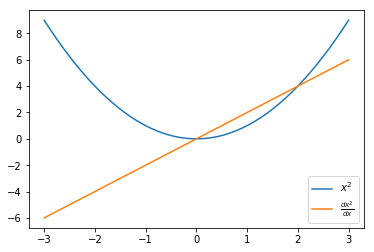

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why automatic differentiation is AMAZING!

In [26]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning: Trying to understand the meaning of that function may result in permanent brain damage!
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

# Yet tf handles the derivative effortlessly!
der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

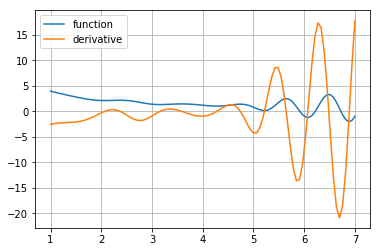

In [27]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic gradients from above, tensorflow also has some optimization methods implemented for us.

In [28]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + 0.5*tf.random_normal([2]))**2) 

step = tf.train.MomentumOptimizer(0.03, 0.5).minimize(loss, var_list=y_guess)

Let's draw a trajectory of a gradient descent in 2D

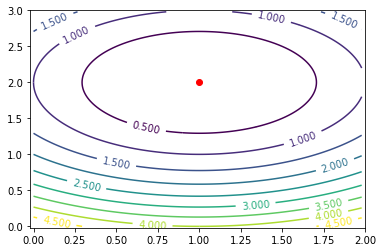

In [30]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# nice figure settings
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

# start animation with empty trajectory
def init():
    line.set_data([], [])
    return (line,)

trajectory = [s.run(y_guess)]

# one animation step (make one GD step)
def animate(i):
    s.run(step)
    trajectory.append(s.run(y_guess))
    line.set_data(*zip(*trajectory))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [31]:
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    # In case the built-in renderers are unavailable, fall back to
    # a custom one, that doesn't require external libraries
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABLdG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQ4IHIyNjQzIDVjNjU3MDQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE1IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAADIbZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB4He8+UME3qAgRXU+O3+/edMJ0DnCMXWPN
eZygE92gs3qdzsl1RjH5VUqIbQW4lbEY1EhCwAAAp+d7WlESNH8y4yoHWdjEy3i5zj0iR5r7oD4c
evRGf5YZpSE2T/MqtpALqtLPBV7Di/jhpp/BE5Hr5txSfEu67UvppgZwAi2i8q+512MwmU2ndWiZ
0/gy29dsLpujNTmKwjGLSMJz2YilEL4r07flZfkmw/NVWvox9hjJ1m9L6gw8Ob76LAgnuCGgc52d
Dha90pVUIyCF8fKxNLt4Gbva9jGQsOR1327NyC2X7ON7gecpbjvz3Mtumnet+DhqiiQX2r6+ex3K
UIboAKQlLQfGXbSRo+zfPXXlcAq497i8YsYhV4qxiPAJOu7czM80g4LGjbRY6+1qIA4l9hm/SuOm
kJhBZIbKIk9WF7RsjjGFOAdS/rNzWx+Oc4WL30dHn9bymJE+/o6VRBxvsG8BcsmPaAMG1vUannqL
i6L3pdl3hHgqFTFNhoreScQKNSVCM7qfSh2BWfXn/oAWuSe5NxbT0yu/Rp2N5gIyqPOjHIlspSgq
xbess6Djpl8fXHUGJZbdH+ex4aWjROxi/9c7iGaE8uOMOB9wPXwXhicJjay35RBRf9DvLHwOVQDF
8F/3WM2et/+aVVjVA4vGmnd2udW7ZM+XwHTxgp9t74x13KyDl5SEbLup2dMZHg1FjkyM7k3RBxuN
wcv99vIZF3502Mtj97eqCA6nq+EFKOvwAak1VMmF6l9o9jHoNBbrKkF5kOoxmxsAZWQ6FHZPGqhA
xdZhsFrOSfdS91UjOPCYwd9//mdCThpuQK8y9aR4CYWf0SH6PFBje3T+Uppd2gaZueG8EyMJSsDf
3zew6EDyNS6CNWV0M6OMzF7htHJaIBdXPtfaFQSRyC9sgHfoMOKstKQHpfrbK0WLXEeyOtczBE+i
LbeT/hflOXKnQuBvXTVP4p2DdqqTzZQcg5iy+dQB0sRzfzKMA9tyrtN3NuT8isMNo53GXkDccYu+
jNnUEY5F6d4fN4eD9p+SxlYvhUVi3nkosieWiluS3/2IFUnY4kJ5jky0ldhLl7nRhFt8NPzrW+CF
4i3g8vVYe2GaZBHog9VQcUyirOnVBxdG1BM51/LOGAGJFflZU7zm2/z4tr+SY7QexJlgcySU4/dy
jlANYfN8kC/bEXOlvjNpYxIWQjrgcRnoKNl1SNoHqljPu/BNaZCeH49BAYbJlhIZRIeXdoh7bSQH
ryNnUxZWsPd/MUq9Hj6nGa9NB3gZFy8gwR85mVrB9j0dOqXJ4DEKv0rkG+BtnOtiPZg/8o4B8UOU
Jt0HR+SxVCIvgeuWBauvS5UlZq0uxbKQFioxdewXSVcedNh8ZoLgT/234NOxIst3FPuPTYQn8Mlh
yDOVtiVbEfJHrszn0YAAGJTn1a+VLpS/jUeaLxxnIzaSWY2AUC4CcBegGkrz13SeKcfhz7/HfPEI
0OBXCV35mSEBAs526ysd5XeSM8LSvV+TjcMhPppYKtV8eDNMdF7crn1qwVzJm3Jfi09llA/l6cz9
UnmfF6WbX6gGvnzoGC06I3qbQepPsoYythH2w/NnyQ6qwBrJxZaszyyBcMpThd1i1k6eXC3SDmsJ
W8q2XEtTOFBeBWCKza/vlyt0q8sb+cKNdMNwv2JntO3rK8Jo30osrz1F3U+xHHQzvVqYKmTYujVp
12UDMvJmLCa6rTNIt84pOlV75ThwG0q2FRt3I6jf4pVWCtHBAm3AJkiDxHyXzD6pr1u82tiGTR+C
L7ZrCc00c8qSY3sidIJEMTrdOFraZPaUfMD5Ay8pK/tgQ4vg1cuHJKhNOCDrLaUEeli72eyYrew6
Xx5vL41axaNHcScR4T6h5hvTefgxmyDHPT+LA6LT12eJfBSLS6webJ4e9ATOXcvZ9Y8bc9gV3yE8
SReHlboFRUeyeCh4AjgycvnNM64dvUfEZngvZ+iDxPIp+HliuUknhiIQ9/IxdyXBKTZN8aioAOge
ID8do/MGFEOtxsELXSWsmk4qZdxCJC9WFuBBjW82uz1Lbz2NqH1kxdI5Uuf/HrYZ03H4BmZR2w0r
F/qhXEu+A2MvJjkZH6C+SZg2nH8NlPkddAhAijN41p2Hib/3UIOXef8NA4tPWIUUom9m9rXqQ8H8
SrrHaww3deWaQ7NhtaONoDm+J8qAHKu5qatxsrgVFCEPTLzs/5gXZBtL9XzENRrQZnxF8EIoISEi
13fmK1fG/KvSN/58QAm5PA+6HXyrIVQ2d2w4c19opOa3qDFYQyXAQQaXnW1Qq21clLFidddW1N7c
DhG0RPvIurSHu2szKUcgulr06HA+Pb3tIfM/OlQns7M2Ku6GWxc9vIdt1DQti1w12fzAmeDwPh+n
d3A2SDZsoK+6mKC6HTNgjWuN67PAQ9DydQTD8mCLCFQN8GXCEOmq8AEtqJYUWIgmxxxM5bcu8dio
2q/UnVfK0ZodmRthMbrz0cxtV053moWAfPqY5c7OEsgyn6auOQGHMhSpZjwwVry2Q3PwAay8V1Db
vsMMFwGhpjQV9bq9msejIe877StnHN++XZUAfY49zLFjUoBWRqIzKD21QmFAILJp4IBpglFkPz3S
AquXjCHm4TEXi5ecp+w32pJ4vzvkW+Nx6DolPo/hUkanT3k3jxFmivCIQ3D1jm15f+eU7YJ4ivuB
0J2twIU7oM6A/DfTsIvy8Gaor08EnVwlY75cwJUEmsNWzwfaSatInR5J9wV4EzZ4XM2kp5tLK1Hy
530PzXt9a6sKimdJkYUh3V++HIO/fEextfjhyTq0vmPijgkUIn16ce5iKS4NpvlOyIMb7gjZgza1
NfPl4VSwczsYFLDNvpG/A